In [1]:
# notebook requires stuff from ./03_classification.ipynb

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shifted
copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.

3. Tackle the Titanic dataset. A great place to start is on Kaggle.

In contribution with <a href="https://www.kaggle.com/amandinesh">Aman Dinesh</a> 

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Importing the dataset
#get parent directory:
import os
parentDirectory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

train = pd.read_csv(os.path.join(parentDirectory, 'datasets', 'titanic', 'train.csv'))
test = pd.read_csv(os.path.join(parentDirectory, 'datasets', 'titanic', 'test.csv'))

In [4]:
# Feature Engineering
# Name
train_test_data = [train, test] # combining train and test data

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Ms            1
Sir           1
Don           1
Mme           1
Countess      1
Capt          1
Lady          1
Jonkheer      1
Name: Title, dtype: int64

In [5]:
# Title Map
# Mr: 0 Miss: 1 Others: 3

title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2,
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3, "Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona": 3, "Mme": 3, "Capt": 3, "Sir": 3}
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [6]:
# Delete unnecessary features from dataset
train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

In [7]:
# Sex
# male: 0 female: 1
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [8]:
# Age 
# Some age is missing Let's use Title's median age for missing Age
# fill missing age with median age for each title {Mr, Mrs, Miss, Others}
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace = True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace = True)

In [9]:
# Bining
# Bining/ Converting Numerical Age to Categorical Value
# feature vector map: child: 0 yound: 1 adult: 2 mid-age: 3 senior: 4
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[ (dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[ (dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4

In [10]:
# Embarked
# Filling missing values
# Fill out missing embark with S embark
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [11]:
# Fare
# Fill missing Fare with median from each Pclass
train['Fare'].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace = True)
test['Fare'].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace = True)

for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[ (dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[ (dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ (dataset['Fare'] > 100), 'Fare'] = 3   

In [12]:
# Cabin
train.Cabin.value_counts()
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)
    
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

In [13]:
# Family Size
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2.0, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
for dataset in train_test_data:
    dataset["FamilySize"] = dataset["FamilySize"].map(family_mapping)
    
features_drop = ["Ticket", "SibSp", "Parch"]
train = train.drop(features_drop, axis = 1)
test = test.drop(features_drop, axis = 1)
train = train.drop(["PassengerId"], axis = 1)

In [14]:
train_data = train.drop('Survived', axis = 1)
target = train['Survived']

test_data = test.drop("PassengerId", axis=1).copy()

y_train = target

train = train.drop(['Survived'], axis = 1)

X_train = train_data.iloc[:, :].values
X_test = test_data.iloc[:, :].values

In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(668, 8)
(668,)
(223, 8)
(223,)


In [51]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'max_depth': range(3, 10), 'n_estimators': np.linspace(10, 100, 10).astype('int') }]

grid_search = GridSearchCV(rfc, param_grid, cv=5, verbose=3)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ........ max_depth=3, n_estimators=10, score=0.821, total=   0.0s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ........ max_depth=3, n_estimators=10, score=0.851, total=   0.0s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ........ max_depth=3, n_estimators=10, score=0.776, total=   0.0s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ........ max_depth=3, n_estimators=10, score=0.789, total=   0.0s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ........ max_depth=3, n_estimators=10, score=0.842, total=   0.0s
[CV] max_depth=3, n_estimators=20 ....................................
[CV] ........ max_depth=3, n_estimators=20, score=0.799, total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=3, n_estimators=20 ....................................
[CV] ........ max_depth=3, n_estimators=20, score=0.851, total=   0.0s
[CV] max_depth=3, n_estimators=20 ....................................
[CV] ........ max_depth=3, n_estimators=20, score=0.806, total=   0.0s
[CV] max_depth=3, n_estimators=20 ....................................
[CV] ........ max_depth=3, n_estimators=20, score=0.805, total=   0.0s
[CV] max_depth=3, n_estimators=20 ....................................
[CV] ........ max_depth=3, n_estimators=20, score=0.842, total=   0.0s
[CV] max_depth=3, n_estimators=30 ....................................
[CV] ........ max_depth=3, n_estimators=30, score=0.806, total=   0.1s
[CV] max_depth=3, n_estimators=30 ....................................
[CV] ........ max_depth=3, n_estimators=30, score=0.858, total=   0.1s
[CV] max_depth=3, n_estimators=30 ....................................
[CV] ........ max_depth=3, n_estimators=30, score=0.791, total=   0.1s
[CV] 

[CV] ........ max_depth=4, n_estimators=30, score=0.872, total=   0.1s
[CV] max_depth=4, n_estimators=40 ....................................
[CV] ........ max_depth=4, n_estimators=40, score=0.813, total=   0.1s
[CV] max_depth=4, n_estimators=40 ....................................
[CV] ........ max_depth=4, n_estimators=40, score=0.873, total=   0.1s
[CV] max_depth=4, n_estimators=40 ....................................
[CV] ........ max_depth=4, n_estimators=40, score=0.791, total=   0.1s
[CV] max_depth=4, n_estimators=40 ....................................
[CV] ........ max_depth=4, n_estimators=40, score=0.820, total=   0.1s
[CV] max_depth=4, n_estimators=40 ....................................
[CV] ........ max_depth=4, n_estimators=40, score=0.857, total=   0.1s
[CV] max_depth=4, n_estimators=50 ....................................
[CV] ........ max_depth=4, n_estimators=50, score=0.828, total=   0.1s
[CV] max_depth=4, n_estimators=50 ....................................
[CV] .

[CV] ........ max_depth=5, n_estimators=50, score=0.880, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ........ max_depth=5, n_estimators=60, score=0.821, total=   0.2s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ........ max_depth=5, n_estimators=60, score=0.866, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ........ max_depth=5, n_estimators=60, score=0.791, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ........ max_depth=5, n_estimators=60, score=0.835, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ........ max_depth=5, n_estimators=60, score=0.872, total=   0.1s
[CV] max_depth=5, n_estimators=70 ....................................
[CV] ........ max_depth=5, n_estimators=70, score=0.813, total=   0.1s
[CV] max_depth=5, n_estimators=70 ....................................
[CV] .

[CV] ........ max_depth=6, n_estimators=70, score=0.827, total=   0.1s
[CV] max_depth=6, n_estimators=70 ....................................
[CV] ........ max_depth=6, n_estimators=70, score=0.857, total=   0.1s
[CV] max_depth=6, n_estimators=80 ....................................
[CV] ........ max_depth=6, n_estimators=80, score=0.791, total=   0.2s
[CV] max_depth=6, n_estimators=80 ....................................
[CV] ........ max_depth=6, n_estimators=80, score=0.866, total=   0.2s
[CV] max_depth=6, n_estimators=80 ....................................
[CV] ........ max_depth=6, n_estimators=80, score=0.791, total=   0.2s
[CV] max_depth=6, n_estimators=80 ....................................
[CV] ........ max_depth=6, n_estimators=80, score=0.812, total=   0.2s
[CV] max_depth=6, n_estimators=80 ....................................
[CV] ........ max_depth=6, n_estimators=80, score=0.865, total=   0.2s
[CV] max_depth=6, n_estimators=90 ....................................
[CV] .

[CV] ........ max_depth=7, n_estimators=90, score=0.784, total=   0.2s
[CV] max_depth=7, n_estimators=90 ....................................
[CV] ........ max_depth=7, n_estimators=90, score=0.827, total=   0.1s
[CV] max_depth=7, n_estimators=90 ....................................
[CV] ........ max_depth=7, n_estimators=90, score=0.872, total=   0.2s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] ....... max_depth=7, n_estimators=100, score=0.799, total=   0.3s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] ....... max_depth=7, n_estimators=100, score=0.858, total=   0.3s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] ....... max_depth=7, n_estimators=100, score=0.776, total=   0.2s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] ....... max_depth=7, n_estimators=100, score=0.827, total=   0.2s
[CV] max_depth=7, n_estimators=100 ...................................
[CV] .

[CV] ........ max_depth=9, n_estimators=10, score=0.761, total=   0.0s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.813, total=   0.0s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.761, total=   0.0s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.842, total=   0.0s
[CV] max_depth=9, n_estimators=10 ....................................
[CV] ........ max_depth=9, n_estimators=10, score=0.865, total=   0.0s
[CV] max_depth=9, n_estimators=20 ....................................
[CV] ........ max_depth=9, n_estimators=20, score=0.828, total=   0.0s
[CV] max_depth=9, n_estimators=20 ....................................
[CV] ........ max_depth=9, n_estimators=20, score=0.821, total=   0.0s
[CV] max_depth=9, n_estimators=20 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:   42.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [54]:
grid_search.best_params_

{'max_depth': 5, 'n_estimators': 60}

In [55]:
grid_search.best_score_

0.8368263473053892

In [56]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(x_test)
accuracy_score(y_test, y_pred)

0.8340807174887892

In [73]:
from sklearn.metrics import precision_score, recall_score

precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)

print("When we claim a passenger will die, it is correct only {}% of the time. Moreover, it only \
detects {}% of the dead.".format(precision, recall))

When we claim a passenger will die, it is correct only 81.71% of the time. Moreover, it only detects 75.28% of the dead.


In [85]:
y_scores = grid_search.predict_proba(x_test)
#y_scores[:, 1] #for positive class

In [86]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores[:, 1])

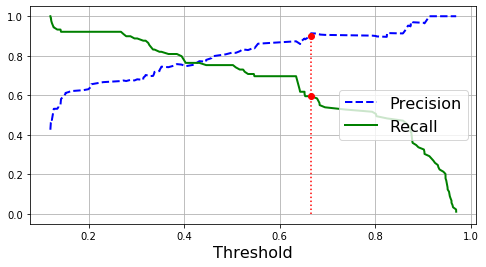

In [89]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    #plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
#plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
#save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

In [95]:
from sklearn.metrics import roc_curve

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_scores[:, 1])

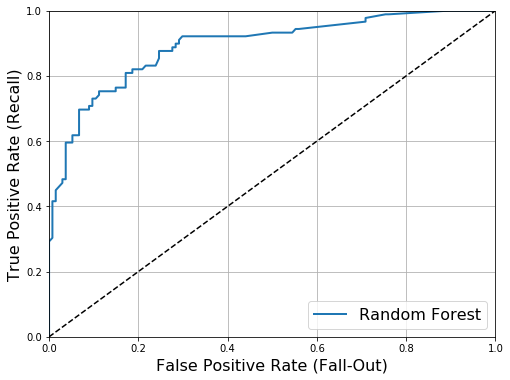

In [99]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

4. Build a spam classifier (a more challenging exercise):
<pre>
• Download examples of spam and ham from <a href="https://spamassassin.apache.org/old/publiccorpus/"> Apache SpamAssassin’s public datasets.</a>
• Unzip the datasets and familiarize yourself with the data format.
• Split the datasets into a training set and a test set.
• Write a data preparation pipeline to convert each email into a feature vector.
Your preparation pipeline should transform an email into a (sparse) vector that
indicates the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.
You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
Finally, try out several classifiers and see if you can build a great spam classifier,
with both high recall and high precision.
</pre>

In [1]:
import os
import tarfile
import urllib

tarfile

<module 'tarfile' from 'c:\\users\\abhishek\\appdata\\local\\programs\\python\\python36\\lib\\tarfile.py'>

In [23]:
HAM_DOWN_PATH = "https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2"
SPAM_DOWN_PATH = "https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2 "

DATA_DIR_PATH = os.path.join('datasets', 'spam')

HAM_PATH = os.path.join(DATA_DIR_PATH, 'ham.tar.bz2')
SPAM_PATH = os.path.join(DATA_DIR_PATH, 'spam.tar.bz2')

if not os.path.isdir(DATA_DIR_PATH):
    os.makedirs(DATA_DIR_PATH)

for path, url in zip([HAM_PATH, SPAM_PATH], [HAM_DOWN_PATH, SPAM_DOWN_PATH]):
    if not os.path.isfile(path):
        urllib.request.urlretrieve(url, path)
    with tarfile.open(path) as tar_file:
        tar_file.extractall(path=DATA_DIR_PATH)

In [28]:
HAM_DIR = os.path.join(DATA_DIR_PATH, 'easy_ham')
SPAM_DIR = os.path.join(DATA_DIR_PATH, 'spam')

ham_files = os.listdir(HAM_DIR)
spam_files = os.listdir(SPAM_DIR)
print("no. of spam files {} and no. of ham files {}. THOU GREAT IMBALANCE".format(len(ham_files), len(spam_files)))

no. of spam files 2551 and no. of ham files 501. THOU GREAT IMBALANCE


In [32]:
import email
import email.policy

In [38]:
with open(os.path.join(HAM_DIR, ham_files[0])) as fp:
    obj = email.message_from_file(fp)

In [82]:
#obj.get_params() #[('text/plain', ''), ('charset', 'us-ascii')]
for key in obj.keys():
    print('\033[1;32;48m {}:'.format(key))
    print('\033[1;33;48m {}'.format(obj.get(name=key)))

 Return-Path:
 <exmh-workers-admin@example.com>
 Delivered-To:
 zzzz@localhost.netnoteinc.com
 Received:
 from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
 Received:
 from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
 Received:
 from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
 Received:
 from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
 Delivered-To:
 zzzz@localhost.netnoteinc.com
 Received:
 from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 

In [102]:
print(obj.get_payload())

    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55

In [184]:
ham_file_objs = []
for fp in ham_files:
    with open(os.path.join(HAM_DIR, fp), 'rb') as file:
        ham_file_objs.append( email.parser.BytesParser(policy=email.policy.default).parse(file) )

spam_file_objs = []
for fp in spam_files:
    with open(os.path.join(SPAM_DIR, fp), 'rb') as file:
        spam_file_objs.append( email.parser.BytesParser(policy=email.policy.default).parse(file) )

In [199]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [200]:
# find alternative

def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)


In [157]:

#[f(x) if condition else g(x) for x in sequence]
pay = [str(x) if x%2==1 else str(x**2) for x in range(10) ]
pay

['0', '1', '4', '3', '16', '5', '36', '7', '64', '9']

In [160]:
''.join([y for y in pay])

'0143165367649'